# Model Building

### Here we are going to build following models for the two Scenarios.
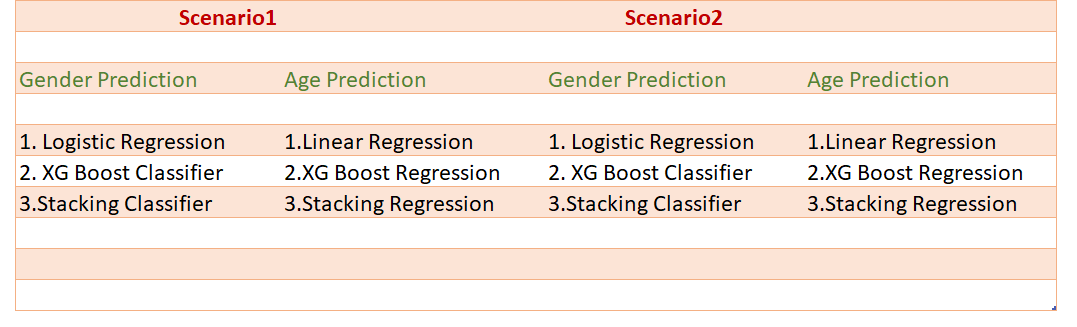


**Utility function**

In [1]:
def calculate_ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)   

## Scenario:1 - Gender Predition

### 1. Logistic Regression

In [2]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import RocCurveDisplay

In [3]:
%%time
#load data
df_train_s2 = pd.read_csv('scenario2_train.csv')
df_test_s2 = pd.read_csv('scenario2_test.csv')

Wall time: 56.2 s


In [4]:
# prepare train test data
y_train_s2 = df_train_s2['gender']
X_train_s2 = df_train_s2.drop(columns=['gender','group','device_id']).fillna(0)

y_test_s2 = df_test_s2['gender']
X_test_s2 = df_test_s2.drop(columns=['gender','group','device_id']).fillna(0)

In [5]:
X_train_s2.head(2)

,age,avg_events,most_active_hour,loc_chng_morning,loc_chng_afternoon,loc_chng_evening,loc_chng_night,10,100,1002,...,loc_cluster_99,loc_cluster_990,loc_cluster_991,loc_cluster_993,loc_cluster_994,loc_cluster_995,loc_cluster_996,loc_cluster_998,loc_cluster_999,loc_cluster_Unknown
0,33,58.4,15.0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,37,1.0,11.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
#scale the data
scaler = StandardScaler()
X_train_s2_scaled =  scaler.fit(X_train_s2).transform(X_train_s2)
X_test_s2_scaled = scaler.fit(X_test_s2).transform(X_test_s2)

In [7]:
# the model
lr=LogisticRegression(C=0.02154,penalty='l2',solver='lbfgs', random_state=0,max_iter=10000).fit(X_train_s2_scaled,y_train_s2) 


#### Accuracy

In [8]:
accuracy = lr.score(X_test_s2_scaled, y_test_s2)
print(f'The accuracy is {accuracy*100} %')

The accuracy is 67.38941351888667 %


The accuracy score fo Scenerio1 - logistic regression is  **67.38%**

#### Confusion matrix

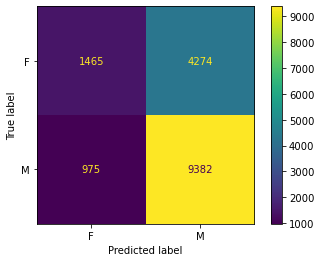

In [9]:
#evaluation  = lr.evaluate(X_test_s2_scaled)
y_pred = lr.predict(X_test_s2_scaled)
ConfusionMatrixDisplay.from_predictions(y_test_s2, y_pred)
plt.show()


#### ROC AUC

In [10]:
score = precision_recall_fscore_support(y_test_s2, y_pred, average='weighted')
print(f'The Precision for secenrio 1 gender prediction using logistic regression is {score[0]*100} %')
print(f'The Recall for secenrio 1 gender prediction using logistic regression is {score[1]*100} %')
print(f'The FScore for secenrio 1 gender prediction using logistic regression is {score[2]*100} %')

The Precision for secenrio 1 gender prediction using logistic regression is 65.61418868871867 %
The Recall for secenrio 1 gender prediction using logistic regression is 67.38941351888667 %
The FScore for secenrio 1 gender prediction using logistic regression is 63.05275784651756 %


C:\Users\chand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


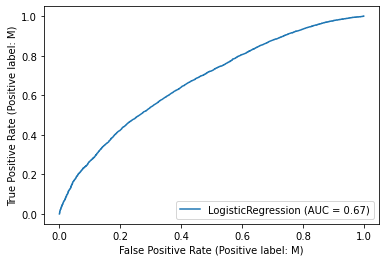

In [11]:
metrics.plot_roc_curve(lr, X_test_s2_scaled, y_test_s2) 
plt.show()

#### KS Statistics

In [12]:
y_pred_proba = lr.predict_proba(X_test_s2_scaled)

In [13]:
y_pred_proba[::,0]

array([0.95066493, 0.58636378, 0.92569645, ..., 0.3276863 , 0.4875611 ,
       0.33743056])

In [14]:
df_evaluation = pd.DataFrame(y_test_s2)
df_evaluation['target'] = df_evaluation.gender.map(lambda x: 1 if x == 'M' else 0)
df_evaluation['probability_negative'] = y_pred_proba[::,0]
df_evaluation['probability_positive'] = y_pred_proba[::,1]

calculate_ks(data=df_evaluation,target="target", prob="probability_positive")

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.896318  0.999996    1395        215     13.47%         3.75%   
2       0.779799  0.896233    1279        330     12.35%         5.75%   
3       0.718072  0.779797    1199        411     11.58%         7.16%   
4       0.690799  0.717962    1138        470     10.99%         8.19%   
5       0.662654  0.690726    1061        549     10.24%         9.57%   
6       0.636914  0.662621    1016        594      9.81%        10.35%   
7       0.598096  0.636850     942        668      9.10%        11.64%   
8       0.534965  0.598000     933        674      9.01%        11.74%   
9       0.424228  0.534893     824        787      7.96%        13.71%   
10      0.000845  0.423719     570       1041      5.50%        18.14%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             13.47

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.896318,0.999996,1395,215,13.47%,3.75%,13.47%,3.75%,9.7
2,0.779799,0.896233,1279,330,12.35%,5.75%,25.82%,9.50%,16.3
3,0.718072,0.779797,1199,411,11.58%,7.16%,37.39%,16.66%,20.7
4,0.690799,0.717962,1138,470,10.99%,8.19%,48.38%,24.85%,23.5
5,0.662654,0.690726,1061,549,10.24%,9.57%,58.63%,34.41%,24.2
6,0.636914,0.662621,1016,594,9.81%,10.35%,68.44%,44.76%,23.7
7,0.598096,0.636850,942,668,9.10%,11.64%,77.53%,56.40%,21.1
8,0.534965,0.598000,933,674,9.01%,11.74%,86.54%,68.15%,18.4
9,0.424228,0.534893,824,787,7.96%,13.71%,94.50%,81.86%,12.6


So the KS is 24.2% at decile 5. So the max prob at this decile is **0.69071**. Also we can see the values for top 3 and bottom 3 deciles

### 2. XG Boost Classifier

In [15]:
#! pip3 install xgboost

In [16]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [17]:
# prepare train test data
y_train_s2_xg = df_train_s2.dropna()['gender']
X_train_s2_xg = df_train_s2.drop(columns=['gender','group','device_id']).dropna()

y_test_s2_xg = df_test_s2.dropna()['gender']
X_test_s2_xg = df_test_s2.drop(columns=['gender','group','device_id']).dropna()

In [18]:
#scale the data
X_train_s2_xg_scaled = scaler.fit(X_train_s2_xg).transform(X_train_s2_xg)
X_test_s2_xg_scaled = scaler.fit(X_test_s2_xg).transform(X_test_s2_xg)

In [19]:
# the grid search and model
xgb_model = xgb.XGBClassifier(use_label_encoder=False)


params = {
        'booster':['gbtree'],
        'objective':['reg:logistic'],
        'eval_metric':['logloss'],
        'min_child_weight': [1, 5],        
        'subsample': [0.8],
        #'colsample_by_tree': [0.5],
        'max_depth': [6], 
        'colsample_bylevel':[0.5],
        'learning_rate': [0.025]

 }

clf_xg = GridSearchCV(xgb_model, params, n_jobs=5, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)
#clf_xg

This classifier would take around 12 mins for 10 fits in total, if time and recources allow we can increase the number of total fits by adding more params to Search Grid

In [20]:
y_train_s2_xg_digits = y_train_s2_xg.map(lambda z: 1 if z =='M' else 0)

In [21]:
%%time
clf_xg.fit(X_train_s2_xg, y_train_s2_xg_digits)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 14min 21s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             n_jobs=5,
        

In [22]:
best_estimator = clf_xg.best_estimator_


In [205]:
best_s2_genger_prediction_model = best_estimator

#### Accuracy

In [24]:
y_test_s2_xg_digits = y_test_s2_xg.map(lambda z: 1 if z =='M' else 0)

In [28]:
accuracy = best_estimator.score(X_test_s2_xg_scaled, y_test_s2_xg_digits)
print(f'The accuracy is {accuracy*100} %')

The accuracy is 73.47288949897049 %


#### Confision Matrix

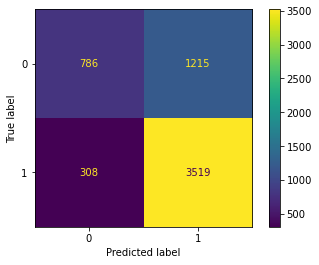

In [30]:
preds = best_estimator.predict(X_test_s2_xg)
#preds
ConfusionMatrixDisplay.from_predictions(y_test_s2_xg_digits, preds)
plt.show()

#### ROC AUC

In [32]:
score = precision_recall_fscore_support(y_test_s2_xg_digits, preds, average='weighted')
print(f'The Precision for secenrio 1 gender prediction using logistic regression is {score[0]*100} %')
print(f'The Recall for secenrio 1 gender prediction using logistic regression is {score[1]*100} %')
print(f'The FScore for secenrio 1 gender prediction using logistic regression is {score[2]*100} %')

The Precision for secenrio 1 gender prediction using logistic regression is 73.48030778079332 %
The Recall for secenrio 1 gender prediction using logistic regression is 73.8675360329444 %
The FScore for secenrio 1 gender prediction using logistic regression is 71.42274283495502 %


C:\Users\chand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


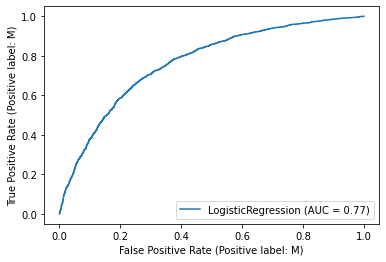

In [33]:
metrics.plot_roc_curve(lr, X_test_s2_xg_scaled, y_test_s2_xg) 
plt.show()

#### KS Statics

In [34]:
y_pred_proba = lr.predict_proba(X_test_s2_xg_scaled)

In [35]:
y_pred_proba[::,0]

array([0.91182305, 0.52257029, 0.85711798, ..., 0.14337204, 0.42969106,
       0.84486869])

In [36]:
df_evaluation = pd.DataFrame(y_test_s2_xg)
df_evaluation['target'] = df_evaluation.gender.map(lambda x: 1 if x == 'M' else 0)
df_evaluation['probability_negative'] = y_pred_proba[::,0]
df_evaluation['probability_positive'] = y_pred_proba[::,1]

In [37]:
calculate_ks(data=df_evaluation,target="target", prob="probability_positive")

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.906819  0.999771     531         52     13.88%         2.60%   
2       0.851152  0.906768     512         71     13.38%         3.55%   
3       0.796394  0.851104     485         98     12.67%         4.90%   
4       0.737454  0.796185     472        110     12.33%         5.50%   
5       0.680288  0.737246     440        143     11.50%         7.15%   
6       0.613388  0.680185     385        198     10.06%         9.90%   
7       0.539876  0.613256     352        230      9.20%        11.49%   
8       0.448554  0.539869     291        292      7.60%        14.59%   
9       0.326320  0.448279     211        372      5.51%        18.59%   
10      0.015067  0.326204     148        435      3.87%        21.74%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             13.88

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.906819,0.999771,531,52,13.88%,2.60%,13.88%,2.60%,11.3
2,0.851152,0.906768,512,71,13.38%,3.55%,27.25%,6.15%,21.1
3,0.796394,0.851104,485,98,12.67%,4.90%,39.93%,11.04%,28.9
4,0.737454,0.796185,472,110,12.33%,5.50%,52.26%,16.54%,35.7
5,0.680288,0.737246,440,143,11.50%,7.15%,63.76%,23.69%,40.1
6,0.613388,0.680185,385,198,10.06%,9.90%,73.82%,33.58%,40.2
7,0.539876,0.613256,352,230,9.20%,11.49%,83.02%,45.08%,37.9
8,0.448554,0.539869,291,292,7.60%,14.59%,90.62%,59.67%,30.9
9,0.326320,0.448279,211,372,5.51%,18.59%,96.13%,78.26%,17.9


Observation

### 3. Stacking Classifier

In [56]:
#! pip3 install mlxtend

In [57]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

In [58]:
y_train_s2_xg_digits = y_train_s2_xg.map(lambda z: 1 if z =='M' else 0)

In [59]:
# 1st set of models
clf1 = LogisticRegression(C=0.02154,penalty='l2',solver='lbfgs', random_state=0,max_iter=10000)
clf2 = RandomForestClassifier(random_state=1, n_estimators=10) 

xgb_boost = xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic", random_state=45, eval_metric='logloss', booster='gbtree',
                             min_child_weight=5, subsample=0.8, max_depth=6, learning_rate=0.025)

clf_stacking = StackingCVClassifier(classifiers=[clf1, clf2], meta_classifier=xgb_boost, use_probas=True, cv=3,random_state=42)

In [64]:
params = { 'random_state':[42], }

grid = GridSearchCV(estimator=clf_stacking, 
                    param_grid=params, 
                    cv=3,
                    refit=True)

grid.fit(X_train_s2_xg_scaled, y_train_s2_xg_digits)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.720 +/- 0.00 {'random_state': 42}
Best parameters: {'random_state': 42}
Accuracy: 0.72


#### Accuracy

In [65]:
y_test_s2_xg_digit = y_test_s2_xg.map(lambda z: 1 if z =='M' else 0)

In [66]:
best_estimator = grid.best_estimator_
accuracy = best_estimator.score(X_test_s2_xg_scaled, y_test_s2_xg_digit)

In [67]:
print(f'The accuracy is {accuracy*100} %')

The accuracy is 73.8675360329444 %


#### Confusion Matrix

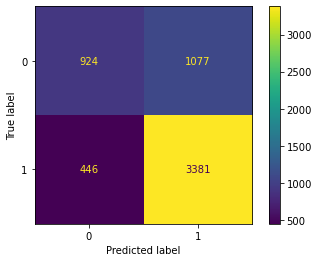

In [68]:
preds = best_estimator.predict(X_test_s2_xg_scaled)
#preds
ConfusionMatrixDisplay.from_predictions(y_test_s2_xg_digit, preds)
plt.show()

#### ROC AUC

In [69]:
score = precision_recall_fscore_support(y_test_s2_xg_digit, preds, average='weighted')
print(f'The Precision for secenrio 1 gender prediction using logistic regression is {score[0]*100} %')
print(f'The Recall for secenrio 1 gender prediction using logistic regression is {score[1]*100} %')
print(f'The FScore for secenrio 1 gender prediction using logistic regression is {score[2]*100} %')

The Precision for secenrio 1 gender prediction using logistic regression is 72.95850529440507 %
The Recall for secenrio 1 gender prediction using logistic regression is 73.8675360329444 %
The FScore for secenrio 1 gender prediction using logistic regression is 72.41688279844553 %


C:\Users\chand\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


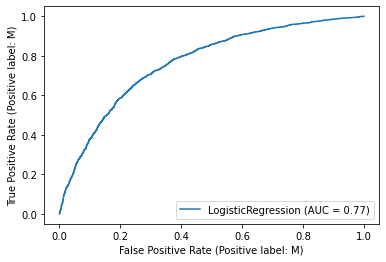

In [70]:
metrics.plot_roc_curve(lr, X_test_s2_xg_scaled, y_test_s2_xg) 
plt.show()

#### KS Statistics

In [71]:
y_pred_proba = lr.predict_proba(X_test_s2_xg_scaled)

In [72]:
y_pred_proba[::,0]

array([0.91182305, 0.52257029, 0.85711798, ..., 0.14337204, 0.42969106,
       0.84486869])

In [73]:
df_evaluation = pd.DataFrame(y_test_s2_xg)
df_evaluation['target'] = df_evaluation.gender.map(lambda x: 1 if x == 'M' else 0)
df_evaluation['probability_negative'] = y_pred_proba[::,0]
df_evaluation['probability_positive'] = y_pred_proba[::,1]

In [74]:
calculate_ks(data=df_evaluation,target="target", prob="probability_positive")

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.906819  0.999771     531         52     13.88%         2.60%   
2       0.851152  0.906768     512         71     13.38%         3.55%   
3       0.796394  0.851104     485         98     12.67%         4.90%   
4       0.737454  0.796185     472        110     12.33%         5.50%   
5       0.680288  0.737246     440        143     11.50%         7.15%   
6       0.613388  0.680185     385        198     10.06%         9.90%   
7       0.539876  0.613256     352        230      9.20%        11.49%   
8       0.448554  0.539869     291        292      7.60%        14.59%   
9       0.326320  0.448279     211        372      5.51%        18.59%   
10      0.015067  0.326204     148        435      3.87%        21.74%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             13.88

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.906819,0.999771,531,52,13.88%,2.60%,13.88%,2.60%,11.3
2,0.851152,0.906768,512,71,13.38%,3.55%,27.25%,6.15%,21.1
3,0.796394,0.851104,485,98,12.67%,4.90%,39.93%,11.04%,28.9
4,0.737454,0.796185,472,110,12.33%,5.50%,52.26%,16.54%,35.7
5,0.680288,0.737246,440,143,11.50%,7.15%,63.76%,23.69%,40.1
6,0.613388,0.680185,385,198,10.06%,9.90%,73.82%,33.58%,40.2
7,0.539876,0.613256,352,230,9.20%,11.49%,83.02%,45.08%,37.9
8,0.448554,0.539869,291,292,7.60%,14.59%,90.62%,59.67%,30.9
9,0.326320,0.448279,211,372,5.51%,18.59%,96.13%,78.26%,17.9


> ## Here we finish Scenerio 1 model building. The conclusion the gender predicition was :

## Scenario:1 - Age Predition

##### We decided to go for Regression for age prediction because we wnted to try both kind of model building techniques that is Classification and Regression. Classification is covered in the Gender prediction scenario, so for this linear regression is a good candidate

## 1. Linear Regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [76]:
%%time
#load data
df_train_s2 = pd.read_csv('scenario1_train.csv')
df_test_s2 = pd.read_csv('scenario1_test.csv')

Wall time: 56.5 s


In [77]:
# conver gender to digits
df_train_s2.gender = df_train_s2.gender.map(lambda x: 1 if x == "M" else 0)
df_test_s2.gender = df_test_s2.gender.map(lambda x: 1 if x == "M" else 0)

In [78]:
df_train_s2 = df_train_s2.drop(columns=['group','device_id']).dropna()
df_test_s2 = df_test_s2.drop(columns=['group','device_id']).dropna()

In [79]:
#scale the data
#scaler = StandardScaler()
#df_train_s2_scaled =  scaler.fit(df_train_s2).transform(df_train_s2)
#df_test_s2_scaled = scaler.fit(df_test_s2).transform(df_test_s2)


In [80]:
#df_train_s2_scaled = pd.DataFrame(df_train_s2_scaled, columns = df_train_s2.columns)
#df_test_s2_scaled = pd.DataFrame(df_test_s2_scaled, columns = df_test_s2.columns)


In [81]:
# prepare train test data
y_train_s2 = df_train_s2['age']
X_train_s2 = df_train_s2.drop(columns=['age'])

y_test_s2 = df_test_s2['age']
X_test_s2 = df_test_s2.drop(columns=['age'])



In [82]:
# the model
reg = LinearRegression().fit(X_train_s2, y_train_s2)

In [87]:
y_pred = reg.predict(X_test_s2)

#### RMSE

In [88]:
rmse = mean_squared_error(y_test_s2, y_pred, squared=False)
print (F"Root mean square error for this model is: {rmse}")

Root mean square error for this model is: 3.796756396581841


#### R-Squared

In [89]:
rs = reg.score(X_test_s2, y_test_s2)
print (F"R-Squared for this model is: {rs}")

R-Squared for this model is: 0.855427431141542


In [105]:
#y_test_s2,y_pred

In [123]:
results.head(100)

,actual,predicted,Error
0,65,52.594639,19.085171
1,47,53.585318,-14.011315
2,31,28.895011,6.790286
3,29,28.384686,2.121773
4,31,29.490736,4.868595
...,...,...,...
95,28,28.272023,-0.971511
96,29,27.410795,5.480016
97,31,31.149339,-0.481738
98,30,29.493467,1.688443


#### Percentage population distribution

In [130]:
results = pd.concat([y_test_s2, pd.Series(y_pred)], axis=1)
results.columns = ['actual','predicted']
results['Error'] = ((results.actual - results.predicted)/results.actual) * 100
#results[(results.Error >= -25) & (results.Error <= 25)].Error.count(),results.Error.count()


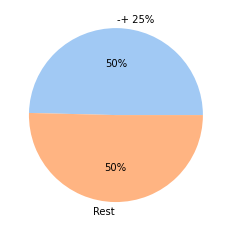

In [131]:
data = [results[(results.Error >= -25) & (results.Error <= 25)].Error.count(), results.Error.count()]
labels = ['-+ 25%', 'Rest']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

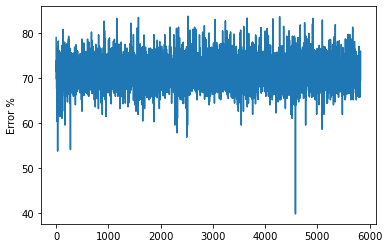

In [164]:
results.Error.plot()
plt.ylabel("Error %")
plt.show()

## 2. XGBoost Regression

In [144]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

In [175]:
# the grid search and model
xgb_model = xgb.XGBRegressor()

In [178]:
xgb_model.fit(X_train_s2, y_train_s2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [180]:
best_estimator = xgb_model

In [204]:
best_s2_age_prediction_model = best_estimator

In [182]:
y_pred = best_estimator.predict(X_test_s2)

#### RMSE

In [183]:
rmse = mean_squared_error(y_test_s2, y_pred, squared=False)
print (F"Root mean square error for this model is: {rmse}")

Root mean square error for this model is: 3.5650317558267726


#### R-Squared

In [184]:
rs = best_estimator.score(X_test_s2, y_test_s2)
print (F"R-Squared for this model is: {rs}")

R-Squared for this model is: 0.87253608991818


#### Percentage population distribution

In [185]:
results = pd.concat([y_test_s2, pd.Series(y_pred)], axis=1)
results.columns = ['actual','predicted']
results['Error'] = ((results.actual - results.predicted)/results.actual) * 100

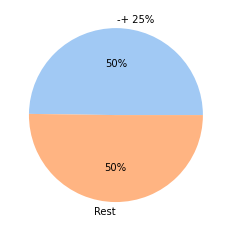

In [186]:
data = [results[(results.Error >= -25) & (results.Error <= 25)].Error.count(), results.Error.count()]
labels = ['-+ 25%', 'Rest']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

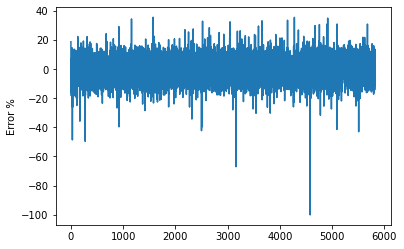

In [187]:
results.Error.plot()
plt.ylabel("Error %")
plt.show()

## 3. Stacking Regressor

In [194]:
from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In [201]:
# 1st set of models
clf1 = LinearRegression()
clf2 = RandomForestRegressor(random_state=1, n_estimators=10) 

xgb_boost = xgb.XGBRegressor()

clf_stacking = StackingRegressor(regressors=[clf1, clf2], meta_regressor=xgb_boost)


params = { 'refit':[True] }

grid = GridSearchCV(estimator=clf_stacking, 
                    param_grid=params, 
                    cv=3,
                    refit=True)

In [202]:
grid.fit(X_train_s2, y_train_s2)
print('Accuracy: %.2f' % grid.best_score_)

C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has

0.820 +/- 0.01 {'refit': True}
Best parameters: {'refit': True}
Accuracy: 0.82


In [207]:
best_estimator = grid.best_estimator_

In [208]:
y_pred = best_estimator.predict(X_test_s2)

C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


#### RMSE

In [209]:
rmse = mean_squared_error(y_test_s2, y_pred, squared=False)
print (F"Root mean square error for this model is: {rmse}")

Root mean square error for this model is: 3.951099215545616


#### R-Squared

In [210]:
rs = best_estimator.score(X_test_s2, y_test_s2)
print (F"R-Squared for this model is: {rs}")

C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\chand\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


R-Squared for this model is: 0.8434344161083178


#### Percentage population distribution

In [211]:
results = pd.concat([y_test_s2, pd.Series(y_pred)], axis=1)
results.columns = ['actual','predicted']
results['Error'] = ((results.actual - results.predicted)/results.actual) * 100

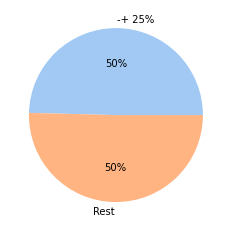

In [212]:
data = [results[(results.Error >= -25) & (results.Error <= 25)].Error.count(), results.Error.count()]
labels = ['-+ 25%', 'Rest']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

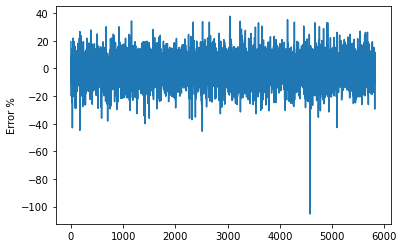

In [213]:
results.Error.plot()
plt.ylabel("Error %")
plt.show()

## This scenerio is not for deployment so we will stop here